## Installing the packages

In [9]:
pip install nxviz

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install --upgrade networkx

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [13]:
!cd /tmp && git clone https://github.com/phanein/deepwalk.git && pip install ./deepwalk

fatal: destination path 'deepwalk' already exists and is not an empty directory.


In [19]:
pip install gensim==3.8.3

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Importing the libraries

In [55]:
import networkx as nx
import nxviz as nv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import manifold
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import pairwise_distances_argmin,cosine_similarity
%matplotlib inline

from deepwalk import graph
import random
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

from itertools import combinations
from collections import defaultdict

## Reading the Dataset

In [3]:
df = pd.read_csv('/Users/parasmistry/Downloads/MSc Artificial Intelligence/Semester 3/Dataset/FoodWebTestData.csv', sep=',')
df.head()

,con.taxonomy,res.taxonomy
0,Vulpes vulpes,Tipulidae
1,Emberiza schoeniclus,Coleoptera
2,Emberiza schoeniclus,Araneidae
3,Vulpes vulpes,Tettigoniidae
4,Emberiza schoeniclus,Chironomidae


In [4]:
foodweb = pd.unique(df[['con.taxonomy', 'res.taxonomy']].values.flatten())
foodweb = sorted(foodweb)
food_web2id = {s:i for i, s in enumerate(foodweb)}
id2foodweb = dict(enumerate(foodweb))

## Build the Graph

In [5]:
G = nx.Graph()

In [6]:
for foodweb_name, id in food_web2id.items():
    G.add_node(id, name=foodweb_name)

In [7]:
for i, series in df.iterrows():
    u = food_web2id[series['con.taxonomy']]
    v = food_web2id[series['res.taxonomy']]
    color = "blue"
    G.add_edge(u, v, color = color)

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


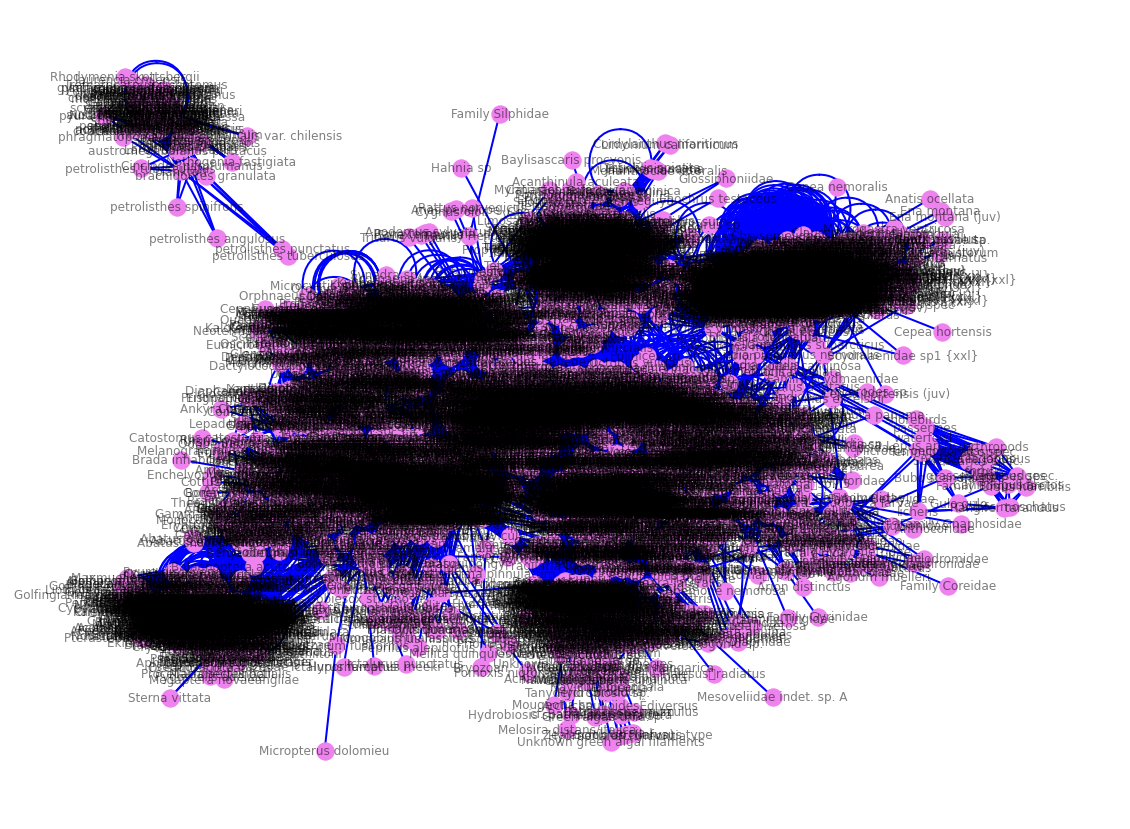

In [11]:
plt.figure(figsize=(20,15))

# calculate posisions in which the nodes are to be placed.
pos = nx.spring_layout(G, k=0.05, seed=2020)

# draw edges
unique_colors = pd.unique(list(nx.get_edge_attributes(G, 'color').values()))
for color in unique_colors:
    edgelist = [e for e, c in nx.get_edge_attributes(G, 'color').items() if c == color]
    nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color=color, width=2)

# draw nodes
nx.draw_networkx_labels(G, pos, id2foodweb, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color='violet', node_size=300)

plt.axis("off")
plt.show()
plt.savefig("/Users/parasmistry/Downloads/MSc Artificial Intelligence/Semester 3/Graph.jpg")

## Building the Word2Vec Model with DeepWalk

In [16]:
n_walks = 30
walk_length = 100
n_workers = 1
representation_size = 4
window_size = 10 #10
seed = 2020

walks = graph.build_deepwalk_corpus(graph.from_networkx(G), num_paths=n_walks, path_length=walk_length, alpha=0, rand=random.Random(seed))
model = Word2Vec(walks, size=representation_size, window=window_size, min_count=0, sg=1, hs=1, workers=n_workers)
model.wv.save_word2vec_format('/Users/parasmistry/Downloads/MSc Artificial Intelligence/Semester 3/FoodWeb_finalembeddings.edgelist')


## Getting the Embeddings

In [17]:
deepwalk_output = pd.read_csv('/Users/parasmistry/Downloads/MSc Artificial Intelligence/Semester 3/FoodWeb_finalembeddings.edgelist', sep=' ', names=['con.taxonomy', 'res.taxonomy'])
embed_pos = {i: [row['con.taxonomy'], row['res.taxonomy']] for i, row in deepwalk_output.iterrows()}
deepwalk_output.head(10)

,con.taxonomy,res.taxonomy
0,5216,4.000000
1,3777,0.853190
2,1318,-0.386378
3,1918,0.126870
4,5065,-0.790162
5,2667,-0.329990
6,4242,0.758275
7,2612,-0.402961
8,3885,-0.695983
9,1365,-0.140308


## Plotting the Graph using DeepWalk

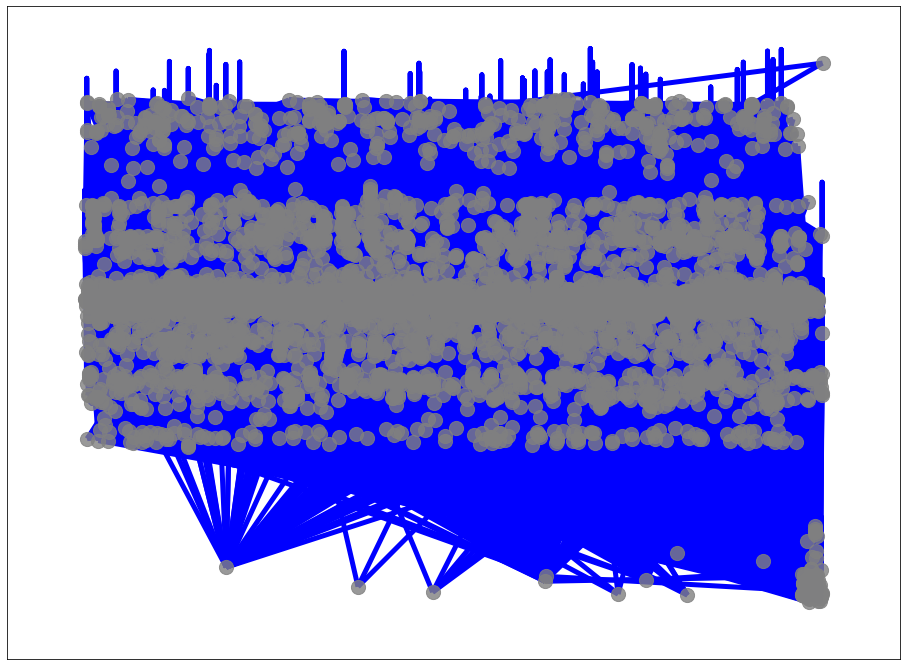

In [18]:
plt.figure(figsize=(16,12))

# draw edges
unique_colors = pd.unique(list(nx.get_edge_attributes(G, 'color').values()))
for color in unique_colors:
    edgelist = [e for e, c in nx.get_edge_attributes(G, 'color').items() if c == color]
    nx.draw_networkx_edges(G, embed_pos, edgelist=edgelist, edge_color=color, width=5)

# draw nodes
nx.draw_networkx_nodes(G, embed_pos, node_color='gray', alpha=0.8, node_size=200)

plt.axis("on")
plt.show()
plt.savefig("/Users/parasmistry/Downloads/MSc Artificial Intelligence/Semester 3/DeepWalk_Graph.jpg")

## Define the TSNE Model

In [23]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for embedding in model.wv.vocab:
        tokens.append(model[embedding])
        labels.append(embedding)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15, 15)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

## Plot the TSNE Model

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


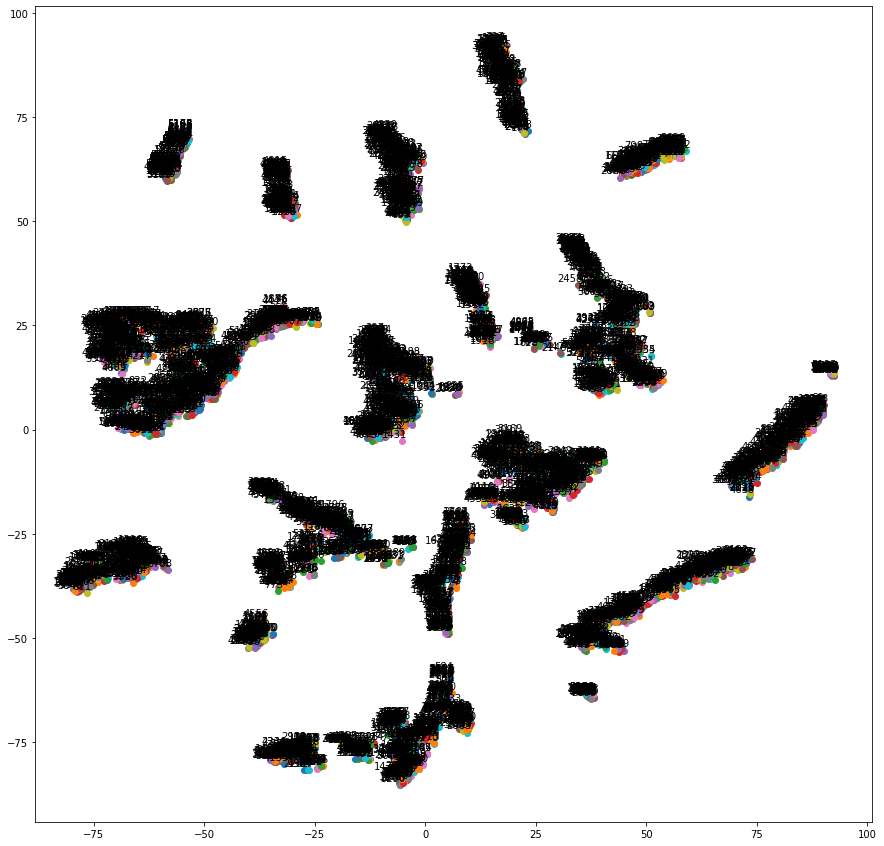

In [24]:
tsne_plot(model)

## Loading the Embeddings

In [26]:
emd = pd.read_csv('/Users/parasmistry/Downloads/MSc Artificial Intelligence/Semester 3/FoodWeb_finalembeddings.edgelist',sep=' ',skiprows=[0],header=None,index_col=0)
idx = emd.index
emd = normalize(emd)

In [27]:
# t-SNE embedding of the journal embedding

print("Computing t-SNE embedding...", end=' ')
tsne = manifold.TSNE(n_components=2, random_state=0, init='pca', perplexity=5.0)
X_tsne = tsne.fit_transform(emd)
print("Finished")

Computing t-SNE embedding... Finished


## Plotting the TSNE model using seaborn

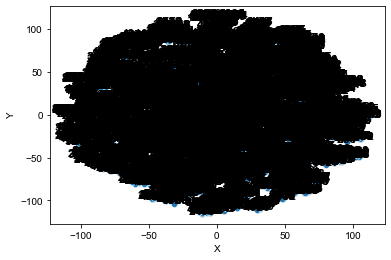

In [30]:
df_tsne = pd.DataFrame(data=X_tsne)
df_tsne.columns = ['X','Y']
df_tsne['id'] = idx #emd.index
df_tsne.head(2)

# Plotting the results
ax = sns.scatterplot(x='X',y='Y',data=df_tsne)
sns.set(rc={'figure.figsize':(11.7,8.27)})

for line in range(0, df_tsne.shape[0]):
    ax.text(df_tsne.X[line], df_tsne.Y[line], df_tsne.id[line], horizontalalignment='center', size='medium', color='black', weight='semibold')


plt.savefig('/Users/parasmistry/Downloads/MSc Artificial Intelligence/Semester 3/Tsne_seaborn.jpg')


## Getting the Pairwise Cosine-Similarity

In [33]:
cos_sim = cosine_similarity(emd)
cos_sim_list = cos_sim.flatten()

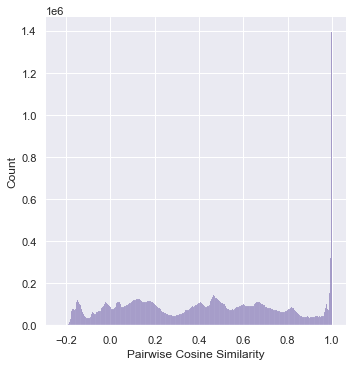

In [34]:
#Plotting the figure

axes = sns.displot(cos_sim_list, color="m")
plt.xlabel('Pairwise Cosine Similarity')

sns.despine(left=True)
plt.savefig('/Users/parasmistry/Downloads/MSc Artificial Intelligence/Semester 3/cosine_similarity.jpg')

## Getting the attributes of the graph

In [45]:
data = ["/Users/parasmistry/Downloads/MSc Artificial Intelligence/Semester 3/Dataset/FoodWebTestData.csv"]
li = []

for f in data:
    tmp = pd.read_csv(f)
    li.append(tmp)

df = pd.concat(li, axis=0, ignore_index=True)
df = df[['con.taxonomy', 'res.taxonomy']]

# create the networkx object
G = nx.from_pandas_edgelist(df,  source='con.taxonomy', target='res.taxonomy')
# How to get the number of nodes
print("Length of nodes is:", len(G.nodes()))
# How to get the number of edges
print("Length of edges is:", len(G.edges()))

Length of nodes is: 5216
Length of edges is: 112488


## Getting main network properties

In [44]:
density = nx.density(G)
print("Density is:", density)

average_clustering = nx.average_clustering(G)
print("Average Clustering", average_clustering)

transitivity = nx.transitivity(G)
print("Transitivity is:", transitivity)

Density is: 0.00827073860795605
Average Clustering 0.2871229368072108
Transitivity is: 0.2892297571346907


## Represent some Centrality Measures

In [50]:
#Compute the betweenness centrality of G
btwn_cen = nx.betweenness_centrality(G)

#sorted the data
sorted(btwn_cen.items(), key=lambda x:x[1], reverse=True)[0:5]

[('Detritus', 0.18788052142846107),
 ('Oligochaeta', 0.11795259828721247),
 ('Phytodetritus', 0.07832366732686005),
 ('Lithobius piceus', 0.060864164892158165),
 ('Salmo trutta', 0.05838879998634719)]

In [51]:
#Compute the degree centrality of G
deg_cen = nx.degree_centrality(G)

#sorted the data
sorted(deg_cen.items(), key=lambda x:x[1], reverse=True)[0:5]

[('Lithobius sp.', 0.09530201342281878),
 ('Linyphiidae (juv)', 0.0887823585810163),
 ('Lithobius sp2 {l}', 0.0813039309683605),
 ('Athous subfuscus (juv) {m}', 0.07938638542665388),
 ('Veigaia nemorensis', 0.0772770853307766)]

In [52]:
#Compute the page rank of G
page_rank = nx.pagerank(G)

#sorted the data
sorted(page_rank.items(), key=lambda x:x[1], reverse=True)[0:5]

[('Phytodetritus', 0.0030000765751635895),
 ('Zooplankton', 0.002470665058389195),
 ('Detritus', 0.002322644694247432),
 ('Sediment', 0.0016850584690392767),
 ('Polychaeta', 0.0016105627278476837)]

In [53]:
#Compute the closeness centrality of G
close_cen = nx.closeness_centrality(G)

#sorted the data
sorted(close_cen.items(), key=lambda x:x[1], reverse=True)[0:5]

[('Detritus', 0.36657056936946397),
 ('Oligochaeta', 0.359436592759114),
 ('Gasterosteus aculeatus', 0.3452306907277322),
 ('Salmo trutta', 0.33212704407237303),
 ('Palaemon serratus', 0.33168684918294644)]

## Represent the Cliques

In [54]:
# get all cliques 
all = nx.find_cliques(G)

# get the largest clique 
largest_clique = sorted(nx.find_cliques(G), key=lambda x:len(x))[-1]
largest_clique

['Mesocyclops edax',
 'Cyclops vernalis',
 'Eucyclops agilis',
 'Cyclops bicuspidatus',
 'Centropages furcatus',
 'Caligus sp.',
 'Scottolana canadensis',
 'Pontella pennata',
 'Centropages hamatus',
 'Myicola major',
 'Nannocalanus sp.',
 'Diosaccus tenuicornis',
 'Ectocyclops phaleratus',
 'Eurytemora affinis',
 'Diacyclops thomasi',
 'Metridia princeps',
 'Diaptomus sp.',
 'Pseudodiaptomus coronatus',
 'Temora stylifera',
 'Eurytemora americana',
 'Labidocera wollastoni',
 'Halicyclops magniceps',
 'Clytemnestra rostrata',
 'Eucalanus pileatus',
 'Labidocera aestiva',
 'Temora turbinata',
 'Oithona colcarva',
 'Acanthocyclops vernalis',
 'Paracalanus crassirostris',
 'Farranula gracilis',
 'Tisbe furcata',
 'Metis sp.',
 'Paracyclops fibriatus',
 'Oncaea sp.',
 'Robertsonia chesapeakensis',
 'Alteutha depressa',
 'Sapphirina sp.',
 'Paracalanus indicus',
 'Macrocyclops sp.',
 'Paralaophonte brevirostris',
 'Ectinosoma compressum',
 'Corycaeus amazonicus',
 'Corycaeus speciosus',
 'H

## Making Recommendation from top 10 data using "Open Triangles Algorithm"

In [56]:
#Initialize the defaultdict:recommended
recommended = defaultdict(int)

#Iterate over all the nodes in G
for a, b in G.nodes(data = True):
#Iterate over all possible triangle relationship combinations
    for e1, e2 in combinations(G.neighbors(a), 2):
    #Check whether n1 and n2 do not have an edge
        if not G.has_edge(e1, e2):
        #Increment edge
            recommended[(e1, e2)] += 1
#Identify the top 10 pairs
every_counts = sorted(recommended.values())
top10_pairs = [pair for pair, count in recommended.items() if count > every_counts[-10]]
print(top10_pairs)

[('Fundulus diaphanus', 'Gasterosteus aculeatus'), ('Agelaius phoeniceus', 'Dendroica'), ('mykorrhiza', 'saphrophytes'), ('Diatoms', 'Dinoflagellata'), ('bacterivorous nematodes', 'fungivorous nematodes'), ('bacterivorous nematodes', 'root feeding nematodes'), ('fungivorous nematodes', 'root feeding nematodes'), ('Ophiurolepis brevirima', 'Ophiurolepis gelida'), ('Ophiurolepis brevirima', 'Ophiosparte gigas')]
